[View in Colaboratory](https://colab.research.google.com/github/stephaniehicks/benchmark-kmeans/blob/master/analyses/Python/MiniBatchKmeans.ipynb)

**Purpose**: This document explore `KMeans()` and `MiniBatchKmeans()` in Python.

**Author**: Stephanie Hicks

**Date**: July 12, 2018

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd

#kmeans
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

Next we try KMeans on the Iris dataset. This classic implementation of the clustering method based on the Lloyd’s algorithm. It consumes the whole set of input data at each iteration.

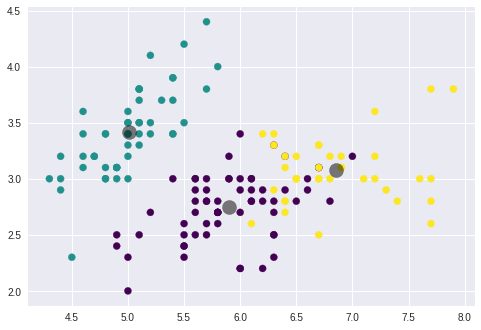

In [35]:
km = KMeans(n_clusters = 3)
km.fit(X) # fitting the input data
labels = km.predict(X) # getting cluster labels

centroids = km.cluster_centers_

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis'); 
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5);

Next we try [`MiniBatchKMeans()`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans) in sklearn. The idea is to [effectively deal with large data](http://scikit-learn.org/stable/modules/scaling_strategies.html), we break the [data into chunks and process](https://adventuresindatascience.wordpress.com/2014/12/30/minibatch-learning-for-large-scale-data-using-scikit-learn/) sequentially (minibatch learning or [online learning](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)). This algorithm uses stochastic gradient descent (SGD), which overcomes the problem of usual gradient-descent-based methods that require all the data to be loaded into memory at once. 

If we want to use the SGD methods for estimation, we want to use the `partial_fit()` function instead of the `fit()` function used above for `KMeans()`. You can break a large dataset into many chunks, successively execute `partial_fit()` on each chunk, then throw the chunk out of memory so the next one can be loaded. 

Inside the `MiniBatchKMeans()` function, the `batch_size` argument controls the size of the mini batches (default = 100). 



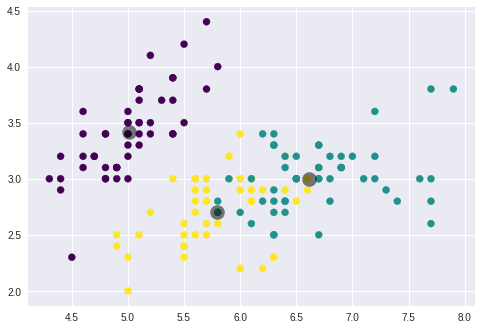

In [39]:
mbkm = MiniBatchKMeans(n_clusters = 3, batch_size=10)
mbkm.partial_fit(X) # fitting the input data
labels = mbkm.predict(X) # getting cluster labels

centroids = mbkm.cluster_centers_

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis'); 
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5);

Relevant documents: 



*   Example of using [logistic regression with the the SGD classifer in scikit-learn](https://github.com/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb) and `partial_fit()` function. 
*   Example of using [`MiniBatchKMeans()` with `partial_fit()`](http://nullege.com/codes/search/sklearn.cluster.MiniBatchKMeans.partial_fit)

